## Using python for proper orthogonal decomposition and dynamic mode decomposition (DMD)

Partial Orthogonal Decomposition (POD) and  Dynamic Mode Decomposition (DMD) are numerical techniques which are used to extract dominant features of dynamical systems from time-series data.

Reduced order models of the dynamical systems being studied can be obtained from both, and both can be thought of as extensions of the Singular Value Decomposition (SVD), so they are relatively similar tools. Their main differences are that DMD modes are invariant in time, while POD modes are not, POD modes are orthogonal, while DMD modes are not and, while POD always uses SVD, some popular applications of DMD use krylov decomposition.

So why would we want to use this techniques?

As mentioned before, turbulent flows are complex non-linear systems, which require special tools in order to analyze them profoundly. With both POD and DMD, meaningful structures within a scalar or vector field can be extracted. For instance, by performing a DMD on a vorticity field, the underlying oscillatory modes of the turbulence structure can be obtained and understood.

Let's consider the simulation of a 2D rotor, performed by the [tutorial](tutorials/incompressibleFluid/rotor2D) of OpenFOAM 11.

![image](./OF11/rotor2D/rotor2D.gif "rotor2D")

First we import the need module. The package [pyDMD](https://pydmd.github.io/PyDMD/index.html) used to analyze and extract coherent structures, and OpenFoam python parser, [Ofpp](https://github.com/xu-xianghua/ofpp), used to read results from the OpenFOAM case.

In [1]:
import numpy as np
try:
    from pydmd import MrDMD, DMD, BOPDMD
    from pydmd.plotter import plot_eigs, plot_summary
    from pydmd.preprocessing import hankel_preprocessing
    from pydmd.plotter import plot_modes_2D
except:
    !pip install pydmd
    from pydmd import MrDMD, DMD, BOPDMD
    from pydmd.plotter import plot_eigs, plot_summary
    from pydmd.preprocessing import hankel_preprocessing
    from pydmd.plotter import plot_modes_2D
try:
    import os
except:
    !pip install os
    import os
try:
    import Ofpp
except:
    !pip install Ofpp
    import Ofpp
import matplotlib.pyplot as plt
import scipy

The case path and the field are defined, and the list of time directories is stored

In [2]:
filepath="./OF11/rotor2D/"
field="U"
## Buscar timesteps del cas, eliminant el 0 perque son condicions inicials ##
TstepDirList=[]
for directory in os.listdir(filepath): # iterate 
    if (directory[0].isnumeric()):
        if("." in directory):
            TstepDirList.append(float(directory))
        else:
            TstepDirList.append(int(directory))
TstepDirList.remove(0)
TstepDirList.sort()
nTsteps=len(TstepDirList)

The field is read for eaach time step and it is stored in an array $U$ of $n$ rows and $T$ columns, where $n$ is the number of cells of the simulation and $T$ is the number of time snapshots.

In [3]:
#initial field
U = np.linalg.norm(
                  Ofpp.parse_internal_field('{}/{}/{}'.format(filepath,TstepDirList[0],field)),
                  axis=1)
#We append the next timesteps
for currTime in TstepDirList[1:]:
    U = np.c_[U,
              np.linalg.norm(
                  Ofpp.parse_internal_field('{}/{}/{}'.format(filepath,currTime,field)),
                  axis=1)
             ]

First the SVD (Singular Value Decomposition) can be computed with `scipy`.  

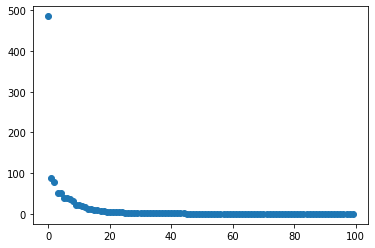

In [4]:
fig = plt.plot(
    scipy.linalg.svdvals(
        np.array([snapshot.flatten() for snapshot in U]).T
    ),
    "o",
)

A [Multi Resolution DMD](https://en.wikipedia.org/wiki/Dynamic_mode_decomposition#Theoretical_and_algorithmic_advancements) is performed, based on a standard DMD, where no truncation of SVD is applied.

The funcion `fit` is the one that actually performs the DMD.

In [5]:
sub_dmd = DMD(svd_rank=-1,tlsq_rank=2, exact=True, opt=True)
dmd = MrDMD(sub_dmd, max_level=4, max_cycles=1)
dmd.fit(U)

/home/robert/.config/jupyterlab-desktop/jlab_server/lib/python3.8/site-packages/pydmd/mrdmd.py:490: ComplexWarning: Casting complex values to real discards the imaginary part
  newX = np.hstack(


The modes can be now reconstructed as OpenFOAM cases.

In [6]:
header = '''/*--------------------------------*- C++ -*----------------------------------*\
  =========                 |
  \\      /  F ield         | OpenFOAM: The Open Source CFD Toolbox
   \\    /   O peration     | Website:  https://openfoam.org
    \\  /    A nd           | Version:  11
     \\/     M anipulation  |
\*---------------------------------------------------------------------------*/
FoamFile
{
    format      ascii;
    class       volScalarField;
    object      U;
}
// * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * * //

dimensions      [0 1 -1 0 0 0 0];

internalField   nonuniform List<scalar> 
'''
BC = ''' 
boundaryField
{
    rotor
    {
        type            movingWallVelocity;
        value           uniform 0;
    }
        freestream
    {
        type            freestreamVelocity;
        freestreamValue uniform (1 0 0);
        value           uniform 0;
    }
    frontAndBack
    {
        type            empty;
    }
}    
'''
for i in range(4):
    if i==0:
        pdata = dmd.partial_reconstructed_data(level=0)
    else:
        pdata += dmd.partial_reconstructed_data(level=i)
    i1=0
    while i1<len(TstepDirList):
        i2=0
        try:
            os.makedirs('{caseDir}DMD/{dmdlevel}/{tstep}'.format(caseDir=filepath,dmdlevel=i,tstep=TstepDirList[i1]))
        except OSError:
            pass
        with open('{caseDir}DMD/{dmdlevel}/{tstep}/{field}'.format(caseDir=filepath,dmdlevel=i,tstep=TstepDirList[i1],field=field),'w') as recFieldFile:
            os.popen('cp -r {caseDir}/{tstep}/polyMesh {caseDir}DMD/{dmdlevel}/{tstep}'.format(caseDir=filepath,dmdlevel=i,tstep=TstepDirList[i1],field=field))
            for row in header:
                recFieldFile.write(row)
            recFieldFile.write(str(pdata.shape[0]))
            recFieldFile.write('\n')
            recFieldFile.write('( \n')
            while i2<pdata.shape[0]:
                recFieldFile.write(str(pdata[i2][i1].real))
                recFieldFile.write('\n')
                i2+=1 
            recFieldFile.write(') \n')
            recFieldFile.write(';')
            for row in BC:
                recFieldFile.write(row)
            i1+=1

And these are the 4 modes:

![image](./OF11/rotor2D/DMD/0/mode0.gif "mode0")

![image](./OF11/rotor2D/DMD/1/mode1.gif "mode0")

![image](./OF11/rotor2D/DMD/2/mode2.gif "mode0")

![image](./OF11/rotor2D/DMD/3/mode3.gif "mode0")